- Costruire un dataset di grafi di spin glass a taglia e connettività fissati (# nodi non troppo alto). Studiare la comparazione tra l'apprendimento della magnetizzazione o dell'energia tra un MLP e una GNN.  Ovviamente in questo caso va ricavata la matrice di adiacenza e la matrice delle features a partire dai grafi per poter allenare l'MLP. (Livello medio)


In [200]:
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

import torch.nn.functional as F

import torchsummary

import os 

#import standard Dataloader

from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Linear



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('Device: ', device)

Device:  cpu


In [201]:
# parameters for the dataset
n_nodes = 10
h = 0
n_samples = 5000

n_dimensions = 5
periodic = True

path = f"datasets"

#load the dataset
dataset = torch.load(f"{path}/dataset_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
graphs = torch.load(f"{path}/graphs_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")


In [202]:
# preapare the data for the MLP
features = []
labels = []

for data, graph in zip(dataset, graphs):
    X = data.x
    A = nx.adjacency_matrix(graph).toarray()
    features.append(torch.cat((X, torch.tensor(A).float() ), dim=1))
    labels.append(data.y)

# print features[0] 
print("input feature: ")
print(features[0].detach().numpy().round(2))

print("label: ")
print(labels[0].detach().numpy())

input feature: 
[[-1.    0.   -0.59 -0.44 -0.99  0.53 -0.27 -0.22  0.68 -0.77  0.64]
 [-1.   -0.59  0.   -0.7   0.26 -0.61  0.63  0.77  0.73 -0.8  -0.07]
 [ 1.   -0.44 -0.7   0.   -0.29  0.43 -0.18  0.14  0.69 -0.52 -0.96]
 [ 1.   -0.99  0.26 -0.29  0.    0.38  0.39  0.28  0.96 -0.76 -0.94]
 [ 1.    0.53 -0.61  0.43  0.38  0.    0.25  0.79  0.12 -0.69 -0.55]
 [-1.   -0.27  0.63 -0.18  0.39  0.25  0.    0.12  0.26 -0.9   0.5 ]
 [-1.   -0.22  0.77  0.14  0.28  0.79  0.12  0.    0.99 -0.84 -0.32]
 [ 1.    0.68  0.73  0.69  0.96  0.12  0.26  0.99  0.    0.37 -0.02]
 [ 1.   -0.77 -0.8  -0.52 -0.76 -0.69 -0.9  -0.84  0.37  0.    0.86]
 [ 1.    0.64 -0.07 -0.96 -0.94 -0.55  0.5  -0.32 -0.02  0.86  0.  ]]
label: 
[0.14400418]


In [203]:
# DA SPOSTARE IN .PY    
def plot_loss( train_losses, test_losses):
    fig = plt.figure()
    epoch = range(1, len(train_losses)+1)
    plt.plot(epoch, train_losses, label='Training Loss')
    plt.plot(epoch, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()
    plt.grid(True)
    plt.show()
    return fig


def train_MLP(model, train_loader, test_loader, num_epochs, patience = 5, model_name='best_model', verbose = True, device= None):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # parameters for patience
    best_loss = np.inf
    patience_counter = 0


    epochs = range(1, num_epochs+1)
    train_losses, test_losses = [], []
    
    print('Training ...')

    for epoch in epochs:
        loss_per_epoch = []
        test_loss_per_epoch = []

        for i, mini_batch in enumerate(train_loader):
            # add the batch to the device
            #mini_batch.to(device)
            # train the model
            train_loss = model.train_step(mini_batch)
            loss_per_epoch.append(train_loss)

        train_losses.append(sum(loss_per_epoch)/len(loss_per_epoch))


        with torch.no_grad():
            """Evaluate the model on test set"""
            for i, mini_batch in enumerate(test_loader):
                #mini_batch.to(device)
                data = mini_batch[0]
                labels = mini_batch[1]
                data, labels = data.to(device), labels.to(device)

                prediction = model.forward(data)
                prediction.to('cpu')
                test_loss = model.criterion(prediction, labels).item()
                test_loss_per_epoch.append(test_loss)
            test_losses.append(sum(test_loss_per_epoch)/len(test_loss_per_epoch))
            
            if test_losses[-1] < best_loss:
                best_loss = test_losses[-1]
                torch.save(model.state_dict(), model_name + '_model.pth')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter == patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
        if verbose:
            print(f"Ep {epoch} \t| Loss {round(train_losses[-1], 5)} \t| Test Loss {round(test_losses[-1], 5)}")


    return  train_losses, test_losses

In [204]:
# create a feedforward MLP

class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels_1, hidden_channels_2, hidden_channels_3, out_channels=1, dropout=0.2, lr = 0.01, wd = 0.0005):
        super(MLP, self).__init__()
        self.lin1 = Linear(in_channels, hidden_channels_1)
        self.lin2 = Linear(hidden_channels_1, hidden_channels_2)
        self.lin3 = Linear(hidden_channels_2, hidden_channels_3)
        self.lin4 = Linear(hidden_channels_3, out_channels)

        self.dropout = torch.nn.Dropout(dropout)


        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr , weight_decay= wd)

    def forward(self, x):

        #print(f"Input size: {x.shape}")

        x = F.relu(self.lin1(x))

        #print(f"Layer 1 output size: {x.shape}")

        x = self.dropout(x)

        x = F.relu(self.lin2(x))

        #print(f"Layer 2 output size: {x.shape}")

        x = self.dropout(x)

        x = F.relu(self.lin3(x))

        #print(f"Layer 3 output size: {x.shape}")

        x = self.dropout(x)

        x = self.lin4(x)

        #print(f"Output size: {x.shape}")

        return x
    
    def train_step(self, data):
        # load the data into the device
        input_data = data[0].to(device)
        label = data[1].to(device)

        #print(f"input data: {input_data.shape} \n label: {label.shape} \n")
        
        # reset the gradients
        self.optimizer.zero_grad()

        # forward pass
        output = self.forward(input_data)

        # reshape the output and the label
        output = output.view(-1)
        label = label.view(-1)
        #print(f"output: {output} \n label: {label} \n")
        
        # compute the loss
        loss = self.criterion(output, label)
        # backward pass
        loss.backward()
        # update the weights
        self.optimizer.step()

        return loss.item()


In [211]:
# training parameters

# set standard parameters for the model

# parameters for the dataset
n_nodes = 10
h = 0


batchsize = 32

# parameters for the model
num_epochs = 200
lr = 1e-3
weight_decay = 1e-4
dropout = 0.4
patience = 30

# parameters for the layers
hidden_channels_1 = 32
hidden_channels_2 = 64
hidden_channels_3 = 64



In [212]:
# create dataloaders for the training and the test set, converting the features into a 1d tensor

features = [torch.flatten(f) for f in features]
labels = [torch.flatten(l) for l in labels]  # it should be already a 1d tensor

# split the dataset into training and test set
n_train = int(0.8*len(features))
n_test = len(features) - n_train

train_dataset = TensorDataset(torch.stack(features[:n_train]), torch.stack(labels[:n_train]))
test_dataset = TensorDataset(torch.stack(features[n_train:]), torch.stack(labels[n_train:]))

train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)



In [213]:
model = MLP(in_channels=features[0].shape[0],   # flatten the input
            hidden_channels_1=hidden_channels_1, 
            hidden_channels_2=hidden_channels_2,
            hidden_channels_3=hidden_channels_3,
            out_channels=1,
            dropout=dropout,
            lr=lr,
            wd=weight_decay)

model.to(device)

torchsummary.summary(model, input_size=(features[0].shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]           3,552
           Dropout-2                   [-1, 32]               0
            Linear-3                   [-1, 64]           2,112
           Dropout-4                   [-1, 64]               0
            Linear-5                   [-1, 64]           4,160
           Dropout-6                   [-1, 64]               0
            Linear-7                    [-1, 1]              65
Total params: 9,889
Trainable params: 9,889
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [208]:
#train the model
model_name = f"MLP_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}_{hidden_channels_1}_{hidden_channels_2}_{hidden_channels_3}_{dropout}_{lr}_{weight_decay}"
train_losses, test_losses = train_MLP(model, train_loader, test_loader, num_epochs, patience, model_name=model_name, verbose = True, device= device)

Training ...
Ep 1 	| Loss 3.81195 	| Test Loss 3.82057
Ep 2 	| Loss 3.80513 	| Test Loss 3.81363
Ep 3 	| Loss 3.80753 	| Test Loss 3.82188
Ep 4 	| Loss 3.80361 	| Test Loss 3.81538
Ep 5 	| Loss 3.79933 	| Test Loss 3.82543
Ep 6 	| Loss 3.7918 	| Test Loss 3.8233
Ep 7 	| Loss 3.80026 	| Test Loss 3.82838
Ep 8 	| Loss 3.79772 	| Test Loss 3.80329
Ep 9 	| Loss 3.79188 	| Test Loss 3.82564
Ep 10 	| Loss 3.79293 	| Test Loss 3.81795
Ep 11 	| Loss 3.79285 	| Test Loss 3.83144
Ep 12 	| Loss 3.79072 	| Test Loss 3.8105
Ep 13 	| Loss 3.79214 	| Test Loss 3.83415
Ep 14 	| Loss 3.79046 	| Test Loss 3.82746
Ep 15 	| Loss 3.7927 	| Test Loss 3.8204
Ep 16 	| Loss 3.77944 	| Test Loss 3.82898
Ep 17 	| Loss 3.78497 	| Test Loss 3.82805
Ep 18 	| Loss 3.78378 	| Test Loss 3.81551
Ep 19 	| Loss 3.78412 	| Test Loss 3.81585
Ep 20 	| Loss 3.78211 	| Test Loss 3.82615
Ep 21 	| Loss 3.77616 	| Test Loss 3.84067
Ep 22 	| Loss 3.77863 	| Test Loss 3.80191
Ep 23 	| Loss 3.77651 	| Test Loss 3.83229
Ep 24 	| Los

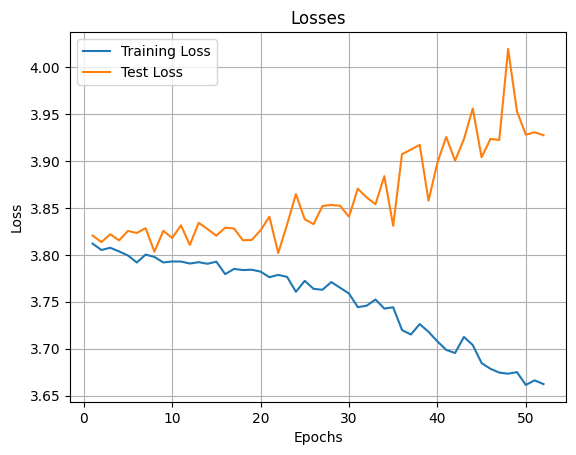

In [209]:
# plot the losses
fig = plot_loss(train_losses, test_losses)
fig.savefig(f"{model_name}_loss.png")

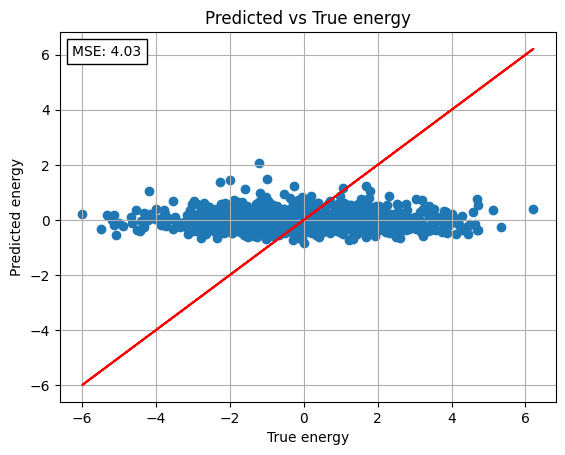

<Figure size 640x480 with 0 Axes>

In [210]:
# show the scatter plot of the predictions
#set seed
torch.manual_seed(42)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

predictions = []
true_value = []

for i, mini_batch in enumerate(test_loader):
    data = mini_batch[0]
    true_value.append(mini_batch[1])
    data = data.to(device)
    prediction = model.forward(data)
    predictions.append(prediction)

predictions = torch.cat(predictions).detach().numpy()
true_value = torch.cat(true_value).detach().numpy()

# save the mean squared error
mse = np.mean((np.array(predictions) - np.array(true_value))**2).round(2)

plt.scatter(true_value, predictions)
plt.plot(true_value, true_value, color='red')
plt.xlabel('True energy')
plt.ylabel('Predicted energy')
plt.title('Predicted vs True energy')

at = AnchoredText(f"MSE: {str(mse)}", frameon=True, loc='upper left')
plt.gca().add_artist(at)

# plot a box similar to the legend to show the MSE
plt.grid(True)
plt.show()

# save the plot
plt.savefig(f"{model_name}_scatter.png")
    